# Гусев Яромир ПМ22-6

# Машинное обучение в задачах идентификации личности по изображению

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from PIL import Image
from tqdm import tqdm, trange
import seaborn as sns
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch

Для данной задчи я выбрал набор данных CelebA_500, который является подмножеством известного набора данных CelebA, который содержит более 200 000 изображений известных знаменитостей из различных областей, таких как кино, спорт, музыка и т.д. CelebA_500 содержит изображения лишь 500 человек, что делает его более компактным и подходящим для экспериментов и тестирования. Решаемой задачей является классификация личности на основе изображения.

In [10]:
img_names = os.listdir('./celebA_500/celebA_imgs/')
print(f'Всего {len(img_names)} картинок')

Всего 23948 картинок


In [11]:
f = open('celebA_500/celebA_anno.txt')
lines = f.readlines()
dict1 = dict()
for i in range(0,500):
    dict1[i] = []
for i in lines:
    z = i.split()
    dict1[int(z[1])].append(z[0])

a = {1:[2,3]}
names = [dict1[i] for i in dict1]
cnts = [len(dict1[i]) for i in dict1]
df = pd.DataFrame({'images':names,'img_counts':cnts})
df

,images,img_counts
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
495,"[000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...",20
496,"[000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...",22
497,"[000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...",22
498,"[000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...",30


Выведем  гистограмму распределения количества картинок для каждого класса

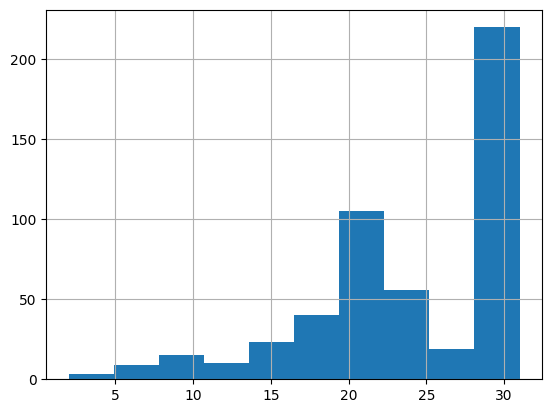

In [12]:
df['img_counts'].hist();

В целом, нет явного дисбаланса классов, так как классы имеют примерно одинаковое количество картинок в выборке.

Выведем 5 случайных картинок людей

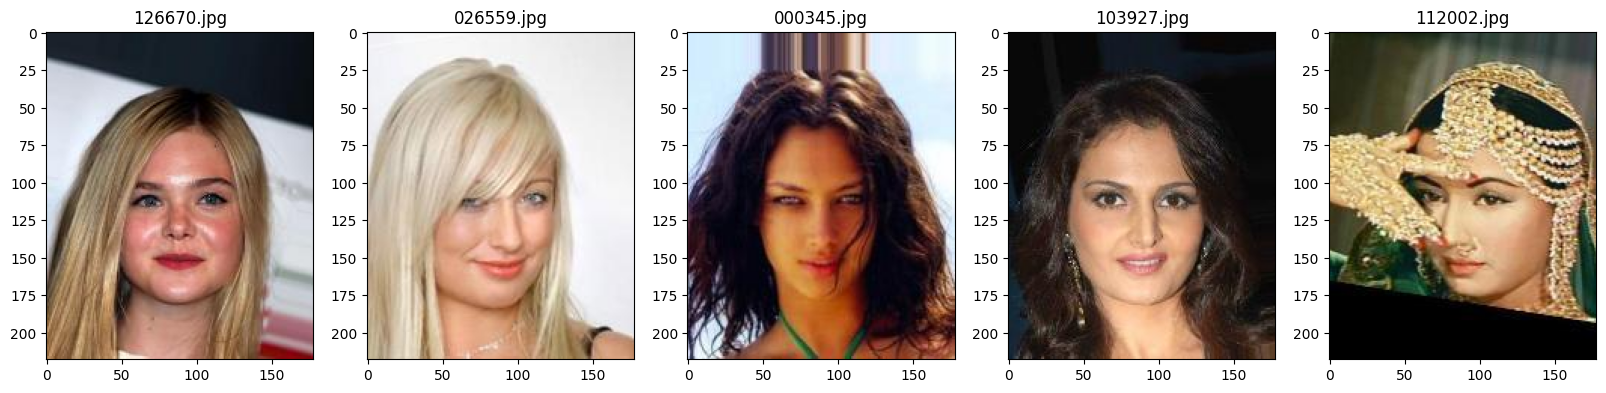

In [18]:
a = [img_names[i] for i in [np.random.randint(0,len(img_names)) for i in range(5)]]
imgs = []
for img in a:
    img = Image.open(os.path.join('celebA_500/celebA_imgs/', img))
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

Выведем 5 картинок одного человека.

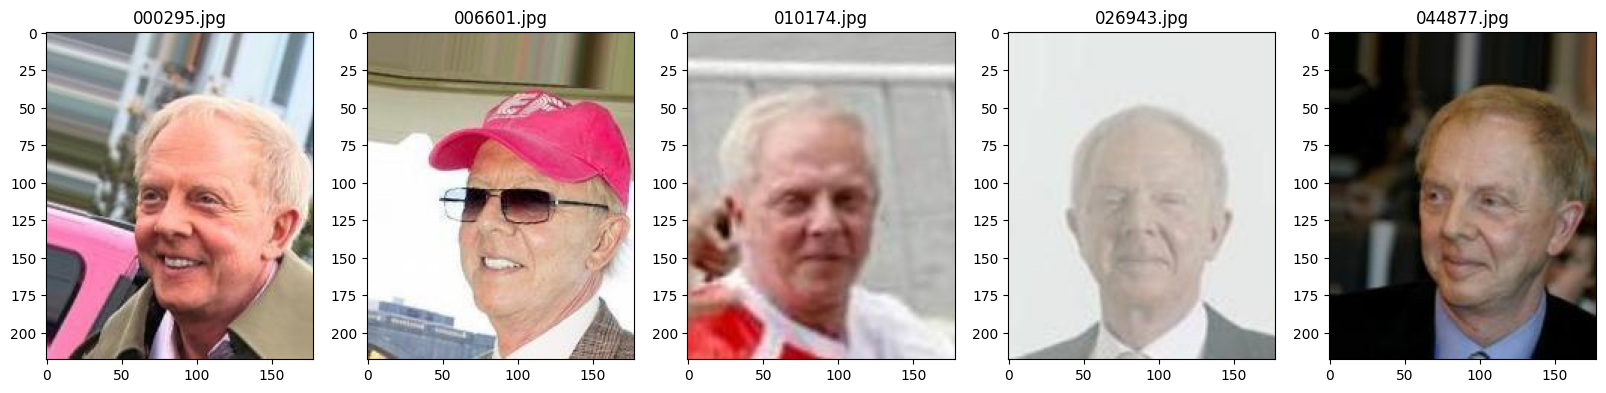

In [20]:
a = df.iloc[np.random.randint(0,len(df))]['images'][:5]
imgs = []
for img in a:
    img = Image.open(os.path.join('celebA_500/celebA_imgs/', img))
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

In [50]:
for i in range(len(lines)):
    lines[i] = lines[i].split()[0]
lines

['000001.jpg',
 '000404.jpg',
 '003415.jpg',
 '004390.jpg',
 '018062.jpg',
 '025244.jpg',
 '027771.jpg',
 '039393.jpg',
 '047978.jpg',
 '049142.jpg',
 '052385.jpg',
 '052623.jpg',
 '053184.jpg',
 '053311.jpg',
 '055834.jpg',
 '058188.jpg',
 '061431.jpg',
 '068154.jpg',
 '084705.jpg',
 '090937.jpg',
 '096324.jpg',
 '100990.jpg',
 '103728.jpg',
 '108341.jpg',
 '110376.jpg',
 '122439.jpg',
 '131731.jpg',
 '134007.jpg',
 '139106.jpg',
 '140935.jpg',
 '000002.jpg',
 '011437.jpg',
 '016335.jpg',
 '017121.jpg',
 '024291.jpg',
 '037082.jpg',
 '045318.jpg',
 '046844.jpg',
 '048360.jpg',
 '055891.jpg',
 '057357.jpg',
 '058209.jpg',
 '058400.jpg',
 '059638.jpg',
 '060925.jpg',
 '063242.jpg',
 '063616.jpg',
 '066809.jpg',
 '077346.jpg',
 '095867.jpg',
 '099877.jpg',
 '105287.jpg',
 '108661.jpg',
 '114336.jpg',
 '114625.jpg',
 '117710.jpg',
 '120280.jpg',
 '125140.jpg',
 '142601.jpg',
 '152380.jpg',
 '000003.jpg',
 '015648.jpg',
 '033840.jpg',
 '038887.jpg',
 '049972.jpg',
 '052374.jpg',
 '053297.j

In [51]:
def load_images_from_folder(folder, lines):
    images = []
    filenames = []
    for filename in tqdm(lines):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            filenames.append(filename)
    return images, filenames


folder = 'celebA_500/celebA_imgs'
images, filenames = load_images_from_folder(folder, lines)

100%|██████████| 12011/12011 [00:06<00:00, 1761.02it/s]


In [ ]:
images

[array([[[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [216, 228, 246],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [218, 230, 248],
         [223, 237, 255],
         [222, 238, 254]],
 
        [[194, 231, 253],
         [194, 231, 253],
         [194, 231, 253],
         ...,
         [220, 232, 250],
         [224, 238, 255],
         [223, 239, 255]],
 
        ...,
 
        [[ 26,  74, 140],
         [  1,  49, 115],
         [ 33,  78, 146],
         ...,
         [ 28,  55, 122],
         [ 30,  56, 123],
         [ 30,  56, 122]],
 
        [[ 14,  61, 129],
         [ 21,  68, 136],
         [ 51,  96, 164],
         ...,
         [ 20,  49, 118],
         [ 24,  50, 120],
         [ 24,  51, 118]],
 
        [[ 56, 103, 171],
         [ 90, 137, 205],
         [131, 176, 244],
         ...,
         [ 20,  49, 118],
  

Преобразуем картинки в плоские численные массивы. Я буду получать:

    Гистограммы цветов: Для каждого канала цвета (красный, зелёный, синий) вычисляются гистограммы с использованием функции cv2.calcHist(). Гистограммы каждого канала сглаживаются и объединяются в один вектор признаков.

    HOG (Histogram of Oriented Gradients) признаки: Эти признаки очень много весят, но при этом не особо влияют на качество классификации, так что их не будем использовать.

    LBP (Local Binary Pattern) признаки: Вычисляются признаки LBP с использованием функции local_binary_pattern() из библиотеки scikit-image. Затем эти признаки нормализуются.

    Статистические признаки: Вычисляются среднее, стандартное отклонение, максимальное и минимальное значения для каждого канала цвета.

Все эти признаки объединяются в один общий вектор признаков для каждого изображения.

In [ ]:
def extract_features(images):
    all_features = []
    
    for img in tqdm(images):
        hist_features = []
        for i in range(3):  # Для каждого канала цвета
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_features.extend(hist.flatten())
        
        # HOG features
#         fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
#                             cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        
#         LBP features
        lbp = local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
        
#         Статистические признаки
        mean = np.mean(img, axis=(0, 1))
        std = np.std(img, axis=(0, 1))
        max_ = np.max(img, axis=(0, 1))
        min_ = np.min(img, axis=(0, 1))
        
        # Объединение признаков
        combined_features = np.hstack([
            hist_features,
#             fd,
            lbp_hist,
            mean,
            std,
            max_,
            min_
        ])
        all_features.append(combined_features)
        
    features_df = pd.DataFrame(all_features)
    
    return features_df

X = extract_features(images)

100%|██████████| 12011/12011 [02:16<00:00, 88.25it/s]


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9,...,796,797,798,799,800,801,802,803,804,805
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,181.045124,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,120.902716,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,106.863442,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,115.390733,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,93.602721,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,114.599191,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,165.123853,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,104.931218,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,87.155603,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0


In [ ]:
targets = []
f = open('celebA_500/celebA_anno.txt')
lines2 = f.readlines()
for i in range(len(lines2)):
    targets.append(int(lines2[i].split()[1]))
targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,


In [ ]:
data = pd.concat([X, pd.Series(targets, name='target')], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


Получился огромный датасет, который я сохраню в csv, чтобы не выполнять feature extraction каждый раз.

In [ ]:
data.to_csv('data.csv')

In [2]:
data = pd.read_csv('data.csv').drop(['Unnamed: 0'], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,797,798,799,800,801,802,803,804,805,target
0,1780.0,184.0,208.0,211.0,209.0,238.0,228.0,256.0,232.0,219.0,...,71.636846,78.730814,74.019823,255.0,255.0,255.0,0.0,0.0,0.0,0
1,14.0,3.0,7.0,10.0,9.0,23.0,34.0,34.0,53.0,55.0,...,53.662434,58.015437,63.356527,226.0,231.0,255.0,0.0,3.0,15.0,0
2,961.0,252.0,259.0,335.0,354.0,427.0,540.0,559.0,669.0,652.0,...,39.664465,47.987976,55.694318,220.0,237.0,255.0,0.0,0.0,0.0,0
3,743.0,142.0,141.0,159.0,176.0,185.0,177.0,234.0,268.0,285.0,...,41.656095,50.670354,62.226688,204.0,239.0,255.0,0.0,0.0,5.0,0
4,2635.0,686.0,624.0,642.0,663.0,627.0,574.0,545.0,456.0,491.0,...,29.577420,43.749106,57.291443,204.0,235.0,255.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12006,1305.0,431.0,600.0,788.0,783.0,740.0,672.0,608.0,526.0,488.0,...,65.399353,67.482488,70.937811,244.0,252.0,255.0,0.0,0.0,0.0,499
12007,417.0,170.0,258.0,310.0,299.0,334.0,320.0,276.0,315.0,314.0,...,80.021627,77.709113,75.365531,255.0,255.0,255.0,0.0,0.0,0.0,499
12008,380.0,146.0,178.0,202.0,237.0,259.0,308.0,315.0,364.0,360.0,...,85.939830,70.010939,59.345278,255.0,219.0,255.0,0.0,0.0,0.0,499
12009,2435.0,886.0,792.0,630.0,636.0,651.0,643.0,672.0,604.0,573.0,...,62.177034,65.818021,69.135773,245.0,253.0,255.0,0.0,0.0,0.0,499


In [3]:
X = data.drop(["target"], axis=1)
y = data["target"]

Так как датасет получился крайне большой, необходимо произвести процедуру понижения размерности (PCA), так как иначе все модели будут учиться очень долго.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(12011, 286)

Осталось всего 286 столбцов, которые теперь я буду использовать для обучения моделей. Выполню разбиение на тренировочную и тестовую выборки. Размер тестовой выборки равен 20% от всего датасета, так как обучающая выборка должна быть достаточно большой для того, чтобы модель могла изучить разнообразные закономерности в данных, а тестовая выборка должна быть достаточно большой для того, чтобы дать надежную оценку обобщающей способности модели. Также будет использован случайны метод разделения данных, чтобы избежать каких-либо предвзятостей или зависимостей между обучающей и тестовой выборками. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y,
                                                  shuffle=True)

Сначала попробую логистическую регрессию.

100%|██████████| 200/200 [01:36<00:00,  2.06it/s]


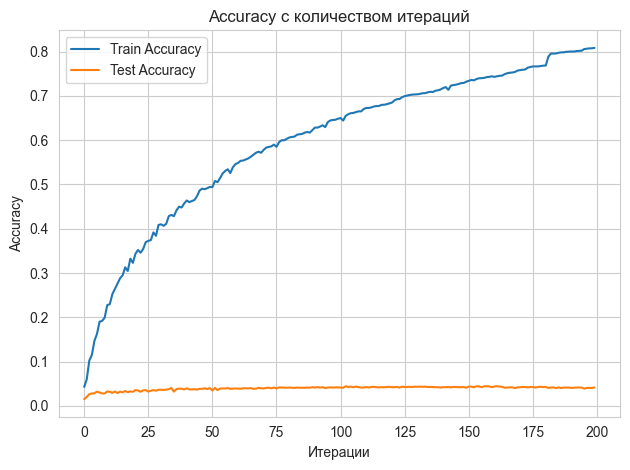

In [63]:
train_accuracy = []
test_accuracy = []

model = LogisticRegression(max_iter=1, warm_start=True)

for i in tqdm(range(1, 201)):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
sns.set_style('whitegrid')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy с количеством итераций')
plt.xlabel('Итерации')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [65]:
y_pred= model.predict(X_test)
accuracy_score(y_pred, y_test)

0.04119850187265917

Логистическая регрессия сталкивается с проблемой переобучения. Попробую случайный лес, так как ему оно безразличнее.

In [68]:
model_rf = RandomForestClassifier(n_jobs=-1, n_estimators=25)

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

accuracy_score(y_pred, y_test)

0.031210986267166042

In [69]:
y_pred = model_rf.predict(X_train)

accuracy_score(y_pred, y_train)

0.9998959200666112

Здесь тоже самое. Попробую еще SVM, KNN, наивный байес и CatBoost.

In [72]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.04203079483978361

In [78]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.026217228464419477

In [75]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.0178942987931752

In [6]:
train_pca_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

In [7]:
model_cb = CatBoostClassifier(loss_function='MultiClass',
                             random_seed=42,
                             task_type='GPU',
                             iterations=200,
                             depth=5,
                             learning_rate=0.2)
model_cb.fit(train_pca_pool)

0:	learn: 6.1619394	total: 962ms	remaining: 3m 11s
1:	learn: 6.0925157	total: 1.87s	remaining: 3m 4s
2:	learn: 6.0582026	total: 2.72s	remaining: 2m 58s
3:	learn: 6.0039172	total: 3.61s	remaining: 2m 56s
4:	learn: 5.9660098	total: 4.51s	remaining: 2m 56s
5:	learn: 5.9246014	total: 5.43s	remaining: 2m 55s
6:	learn: 5.8683982	total: 6.34s	remaining: 2m 54s
7:	learn: 5.8336079	total: 7.23s	remaining: 2m 53s
8:	learn: 5.7725195	total: 8.04s	remaining: 2m 50s
9:	learn: 5.7331708	total: 8.82s	remaining: 2m 47s
10:	learn: 5.7010467	total: 9.6s	remaining: 2m 44s
11:	learn: 5.6754101	total: 10.4s	remaining: 2m 43s
12:	learn: 5.6320392	total: 11.3s	remaining: 2m 42s
13:	learn: 5.5849744	total: 12.1s	remaining: 2m 40s
14:	learn: 5.5561950	total: 12.8s	remaining: 2m 38s
15:	learn: 5.5294953	total: 13.5s	remaining: 2m 35s
16:	learn: 5.4977021	total: 14.2s	remaining: 2m 33s
17:	learn: 5.4568280	total: 15s	remaining: 2m 31s
18:	learn: 5.4287614	total: 15.6s	remaining: 2m 29s
19:	learn: 5.3930225	total

In [9]:
y_pred = model_cb.predict(X_test)
accuracy_score(y_test, y_pred)

0.05160216396171453

В целом, методы классического машинного обучения намного хуже справляются с картинками, чем методы глубокого обучения, так что сейчас попробуем дообучить нейронную сеть

In [27]:
def get_paths(dataset_type='train'):
    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_500/celebA_train_split.txt')
    lines = f.readlines()
    f.close()

    lines = [i.strip().split() for i in lines]
    lines = [i[0] for i in lines if int(i[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_500/celebA_imgs/', filename))
    
    return np.array(images_paths)

class celebA(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 

        sample = {
            'image': self.transform(image),
            'label': label,
        }
        
        return (sample['image'], sample['label'])

    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

In [28]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform2 = transforms.Compose([
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_data = celebA('train', transform2)
val_data = celebA('val', transform)
test_data = celebA('test', transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [29]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8544
1878
1589
267
59
50


In [32]:
for i in timm.list_models():
    if i.find('inception')!= -1:
        print(i)

inception_next_base
inception_next_small
inception_next_tiny
inception_resnet_v2
inception_v3
inception_v4


In [58]:
import timm

model = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=500)
model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [59]:
def train(model, train_loader, val_loader, optimizer, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    loss_fn = nn.CrossEntropyLoss()
    best_model_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('Эпоха %d из %d' % (epoch+1, epochs))        

        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            optimizer.zero_grad()

            Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)
            current_train_correct += torch.sum(preds == Y_batch)

        train_loss = current_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_loader.dataset)
        train_full_acc.append(train_acc)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                X_val = inputs.to(device)
                Y_val = labels.to(device)

                outputs = model(X_val)
                val_loss = loss_fn(outputs, Y_val)
                preds = torch.argmax(outputs, 1)
                current_val_correct += torch.sum(preds == Y_val)
                current_val_loss += val_loss.item() * X_val.size(0)
                
        val_acc = current_val_correct / len(val_loader.dataset)
        val_loss = current_val_loss / len(val_loader.dataset)
          
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = deepcopy(model.state_dict())

    return best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc

In [60]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=5)

Эпоха 1 из 5
train acc = 0.21%
val acc = 0.69%
Эпоха 2 из 5
train acc = 0.96%
val acc = 2.29%
Эпоха 3 из 5
train acc = 4.13%
val acc = 7.19%
Эпоха 4 из 5
train acc = 13.42%
val acc = 20.77%
Эпоха 5 из 5
train acc = 33.04%
val acc = 34.56%


5 эпох действительно мало для обучения нейронной сети, хотя результат уже виден. Попробую дообучить еще 10 эпох, но при этом поменяв learning_rate на 0.0001, так как стандартно в оптимизаторе AdamW стоит 0.001, что является нормальным для первых эпох, но многовато для последующих.

In [61]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Эпоха 1 из 10
train acc = 65.06%
val acc = 55.48%
Эпоха 2 из 10
train acc = 75.25%
val acc = 58.04%
Эпоха 3 из 10
train acc = 81.87%
val acc = 60.60%
Эпоха 4 из 10
train acc = 86.70%
val acc = 62.94%
Эпоха 5 из 10
train acc = 91.58%
val acc = 64.06%
Эпоха 6 из 10
train acc = 95.58%
val acc = 64.38%
Эпоха 7 из 10
train acc = 97.90%
val acc = 65.87%
Эпоха 8 из 10
train acc = 98.93%
val acc = 67.47%
Эпоха 9 из 10
train acc = 99.50%
val acc = 66.56%
Эпоха 10 из 10
train acc = 99.81%
val acc = 66.77%


Получилось всего 67% на валидационной выборке, что относительно мало. Я пробовал менять различные параметры, максимум получалось 77% с этой моделью (прикладываю скриншот). Попробую другую модель, которая уже предобучена на датасете с фотографиями лиц и дообучу ее на своем датасете.

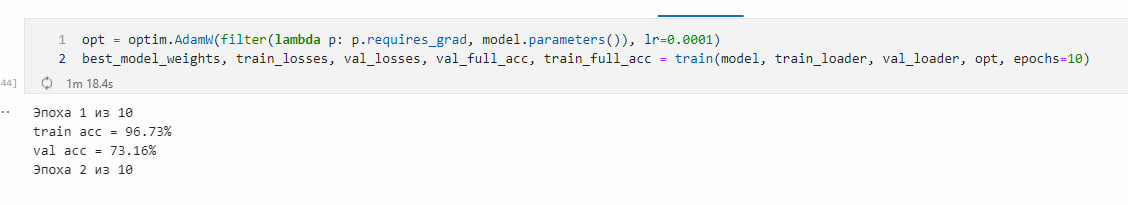

In [45]:
! git clone https://github.com/timesler/facenet-pytorch.git

Cloning into 'facenet-pytorch'...
"mv" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [53]:
! chcp 65001

Active code page: 65001


In [52]:
! dir models

 Volume in drive C has no label.
 Volume Serial Number is 0CD1-44D3

 Directory of c:\Users\yarom\work_study\course work\models

12.05.2024  18:53    <DIR>          .
12.05.2024  18:53    <DIR>          ..
12.05.2024  18:53            11 394 inception_resnet_v1.py
12.05.2024  18:53            21 667 mtcnn.py
12.05.2024  18:53    <DIR>          utils
               2 File(s)         33 061 bytes
               3 Dir(s)  143 444 967 424 bytes free


Возьмем модель Inception-Resnet-V1, так как она сочетает в себе идеи из архитектур Inception и Resnet и является одной из лучших моделей для распознавания лиц.

Основные особенности Inception-ResNet-V1:

1. Inception-модули позволяют сети эффективно масштабироваться и обрабатывать информацию на различных уровнях абстракции и масштабах. Это достигается за счет использования параллельных сверточных операций с различными размерами фильтров (1x1, 3x3, 5x5) и последующим объединением результатов.
2. Вместо того чтобы просто стекать слои, как в традиционных сетях, Inception-ResNet вводит остаточные соединения, которые позволяют градиентам течь непосредственно через архитектуру сети без ослабления на глубоких уровнях. Эти соединения помогают бороться с проблемой исчезающих градиентов при обучении очень глубоких сетей.

3. Так как Inception-ResNet-V1 использует идеи из Inception и Resnet, то гибридизация этих двух архитектур предлагает баланс между глубиной и шириной сети, что позволяет эффективно обрабатывать сложные признаки и обучаться быстрее по сравнению с отдельными архитектурами.


In [62]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

In [63]:
for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True)

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [65]:
def train(model, train_loader, val_loader, optimizer, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    loss_fn = nn.CrossEntropyLoss()
    best_model_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('Эпоха %d из %d' % (epoch+1, epochs))        

        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            optimizer.zero_grad()

            Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)
            current_train_correct += torch.sum(preds == Y_batch)

        train_loss = current_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_loader.dataset)
        train_full_acc.append(train_acc)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                X_val = inputs.to(device)
                Y_val = labels.to(device)

                outputs = model(X_val)
                val_loss = loss_fn(outputs, Y_val)
                preds = torch.argmax(outputs, 1)
                current_val_correct += torch.sum(preds == Y_val)
                current_val_loss += val_loss.item() * X_val.size(0)
                
        val_acc = current_val_correct / len(val_loader.dataset)
        val_loss = current_val_loss / len(val_loader.dataset)
          
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = deepcopy(model.state_dict())

    return best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc

In [66]:
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=10)

Эпоха 1 из 10
train acc = 59.77%
val acc = 90.63%
Эпоха 2 из 10
train acc = 91.26%
val acc = 93.13%
Эпоха 3 из 10
train acc = 92.90%
val acc = 92.76%
Эпоха 4 из 10
train acc = 94.34%
val acc = 93.08%
Эпоха 5 из 10
train acc = 94.38%
val acc = 92.60%
Эпоха 6 из 10
train acc = 93.13%
val acc = 92.33%
Эпоха 7 из 10
train acc = 92.52%
val acc = 91.85%
Эпоха 8 из 10
train acc = 92.59%
val acc = 91.53%
Эпоха 9 из 10
train acc = 93.97%
val acc = 91.91%
Эпоха 10 из 10
train acc = 94.56%
val acc = 91.48%


Отлично, получилось целых 93% на валидационной выборке. Выведу графики обучения.

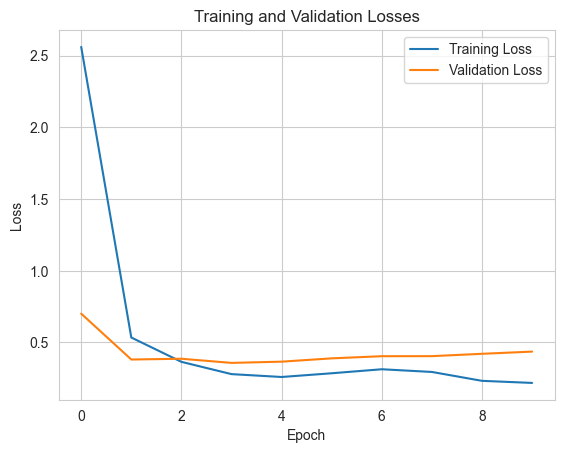

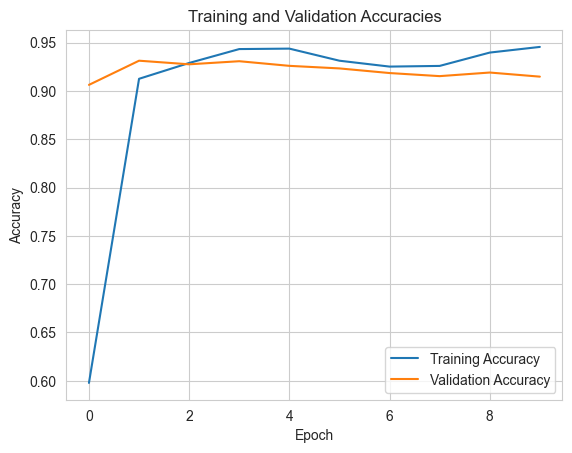

In [72]:
train_full_acc_cpu = []
for i in train_full_acc:
    train_full_acc_cpu.append(i.cpu().numpy())

val_full_acc_cpu = []
for i in val_full_acc:
    val_full_acc_cpu.append(i.cpu().numpy())

sns.set_style('whitegrid')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_full_acc_cpu, label='Training Accuracy')
plt.plot(val_full_acc_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

Посмотрим accuracy на тестовой выборке.

In [73]:
def test_result(model, test_loader):
    model.eval()
    with torch.no_grad():
        current_test_acc = 0
        for inputs, labels in test_loader:
            X_test = inputs.to(device)
            Y_test = labels.to(device)
            outputs = model(X_test)
            preds = torch.argmax(outputs, 1)
            current_test_acc += torch.sum(Y_test == preds)
    print('Correct answers: {} from {} '\
          .format(current_test_acc, len(test_data)))
    test_acc = current_test_acc / len(test_data)
    print('Test accuracy = {:.2f}%'.format(test_acc*100))

In [74]:
best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

best_model.load_state_dict(best_model_weights)

test_result(best_model.to(device), test_loader)

Correct answers: 1489 from 1589 
Test accuracy = 93.71%


c:\Users\yarom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
